# **MEMBANGUN MODEL KLASIFIKASI** UNTUK REKOMENDASI MATERI BERDASARKAN KESALAHAN USER SAAT MENJAWAB SOAL


### IMPORT LIBRARY

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

### LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset soal
file_path='/content/drive/My Drive/Juliasmita/Bangkit2024/Capstone_Project/CodeyAPP/dataset/Python_Programming_Questions_Dataset_bersih.csv'
data = pd.read_csv(file_path)
data.head()

,Instruction,Input,Output
0,Create a function in Python which takes a list...,"[3, 4, 5]",def sum_squares(nums):\n result = 0\n fo...
1,Design a function in Python that sorts a list ...,"['red', 'green', 'orange']",def sort_list_alphabetically(input_list): \n ...
2,Edit the following Python code such that it wi...,"days = [""Monday"", ""Thuesday"", ""Wednesday"", ""Th...","days = [""Monday"", ""Tuesday"", ""Wednesday"", ""Thu..."
3,Create a Python program to check if an integer...,Integer : 10,def is_divisible_by_5(number):\n if (number...
4,Create a Python algorithm to calculate the tar...,"subtrahend: 10\nlist: [4, 3, 8, 6, 5]","def target_sum(subtrahend, lst):\n target_s..."


In [ ]:
data['text'] = data['Instruction']

# Menambah kolom materi
def categorize_question(Instruction):
    if re.search(r'\b(print|hello world|basic)\b', Instruction, re.IGNORECASE):
        return 'Introduction Python'
    elif re.search(r'\b(\+|\-|\*|\/|\%|\*\*|==|!=|<|>|<=|>=|=)\b', Instruction):
        return 'Operator'
    elif re.search(r'\b(int|float|string|bool|type)\b', Instruction, re.IGNORECASE):
        return 'Data Type'
    elif re.search(r'\b(list|tuple|dict|set|array)\b', Instruction, re.IGNORECASE):
        return 'Data Structure'
    elif re.search(r'\b(if|else|while|for|break|continue)\b', Instruction, re.IGNORECASE):
        return 'Control Structure'
    elif re.search(r'\b(def|function|return)\b', Instruction, re.IGNORECASE):
        return 'Function'
    elif re.search(r'\b(class|object|inheritance|method|self)\b', Instruction, re.IGNORECASE):
        return 'OOP'
    else:
        return 'Lainnya'

# Menerapkan pada dataset
data['materi'] = data['Instruction'].apply(categorize_question)

# Menambahkan kolom ID soal
data['question_id'] = data.index

data.head()

,Instruction,Input,Output,text,materi,question_id
0,Create a function in Python which takes a list...,"[3, 4, 5]",def sum_squares(nums):\n result = 0\n fo...,Create a function in Python which takes a list...,Data Structure,0
1,Design a function in Python that sorts a list ...,"['red', 'green', 'orange']",def sort_list_alphabetically(input_list): \n ...,Design a function in Python that sorts a list ...,Data Structure,1
2,Edit the following Python code such that it wi...,"days = [""Monday"", ""Thuesday"", ""Wednesday"", ""Th...","days = [""Monday"", ""Tuesday"", ""Wednesday"", ""Thu...",Edit the following Python code such that it wi...,Introduction Python,2
3,Create a Python program to check if an integer...,Integer : 10,def is_divisible_by_5(number):\n if (number...,Create a Python program to check if an integer...,Control Structure,3
4,Create a Python algorithm to calculate the tar...,"subtrahend: 10\nlist: [4, 3, 8, 6, 5]","def target_sum(subtrahend, lst):\n target_s...",Create a Python algorithm to calculate the tar...,Data Structure,4


In [ ]:
# Menampilkan semua data
pd.set_option('display.max_rows', None)
print(data)

                                            Instruction  \
0     Create a function in Python which takes a list...   
1     Design a function in Python that sorts a list ...   
2     Edit the following Python code such that it wi...   
3     Create a Python program to check if an integer...   
4     Create a Python algorithm to calculate the tar...   
5     Write a Python program to generate a Fibonacci...   
6     Identify the output of the following python co...   
7     Create a Python program to sort a list of tupl...   
8     Please generate a Python script that calculate...   
9               Fix the following syntax in Python code   
10    Write a Python function which takes in an argu...   
11    Generate a code snippet to print a pattern of ...   
12    Write a python program to successfully insert ...   
13    Create an algorithm in Python to find the firs...   
14    Generate a function in Python to convert a giv...   
15    Suggest a way to randomize the order of the fo... 

### PREPROCESSING DATA

In [ ]:
# Tokenisasi dan padding instruksi
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Instruction'])
X = tokenizer.texts_to_sequences(data['Instruction'])
X = pad_sequences(X, maxlen=100)

# Mengonversi target 'materi' ke label numerik
label_mapping = {label: idx for idx, label in enumerate(data['materi'].unique())}
data['materi_label'] = data['materi'].map(label_mapping)
y = to_categorical(data['materi_label'], num_classes=len(label_mapping))

# Membagi data menjadi train dan test
print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

X shape: (7560, 100)
y shape: (7560, 8)
Train shape: (6048, 100) (6048, 8)
Test shape: (1512, 100) (1512, 8)



### MEMBANGUN MODEL


In [ ]:
# Membangun model hyperparameter tuning
def build_model(hp):
    model = Sequential()
    embedding_dim = hp.Int('embedding_dim', min_value=50, max_value=200, step=50)
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=100))
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(len(label_mapping), activation='softmax'))

    # Learning rate sebagai hyperparameter
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Membuat tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='tuning',
    project_name='lstm_hyperparameter_tuning'
)

# Melakukan hyperparameter tuning
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_test, y_test),
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Trial 3 Complete [00h 11m 28s]
val_accuracy: 0.8330026566982269

Best val_accuracy So Far: 0.9761904776096344
Total elapsed time: 00h 31m 09s


In [ ]:
# Mendapatkan hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Hasil terbaik
print("Best embedding dimension:", best_hps.get('embedding_dim'))
print("Best LSTM units:", best_hps.get('lstm_units'))
print("Best dropout rate:", best_hps.get('dropout_rate'))
print("Best learning rate:", best_hps.get('learning_rate'))

Best embedding dimension: 100
Best LSTM units: 256
Best dropout rate: 0.2
Best learning rate: 0.01


In [ ]:
# Membangun model menggunakan hyperparameter terbaik
model = tuner.hypermodel.build(best_hps)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=100))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_mapping), activation='softmax', kernel_regularizer=l2(0.01)))

# Compile
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### TRAIN MODEL

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

# Training model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks= callbacks
)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.4459 - loss: 1.7928 - val_accuracy: 0.7698 - val_loss: 0.8679 - learning_rate: 0.0100
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.8217 - loss: 0.6708 - val_accuracy: 0.9008 - val_loss: 0.4242 - learning_rate: 0.0100
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 139ms/step - accuracy: 0.9303 - loss: 0.3711 - val_accuracy: 0.9444 - val_loss: 0.2969 - learning_rate: 0.0100
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.9481 - loss: 0.2920 - val_accuracy: 0.9570 - val_loss: 0.2376 - learning_rate: 0.0100
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accuracy: 0.9553 - loss: 0.2517 - val_accuracy: 0.9616 - val_loss: 0.2460 - learning_rate: 0.0100
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accuracy: 0.9668 - loss: 0.2034 - val_accuracy: 0.9683 - val_loss: 0.1934 - learning_rate: 0.0100
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accuracy: 0.9

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9776 - loss: 0.1580
Test Loss: 0.16537784039974213
Test Accuracy: 0.9755290746688843


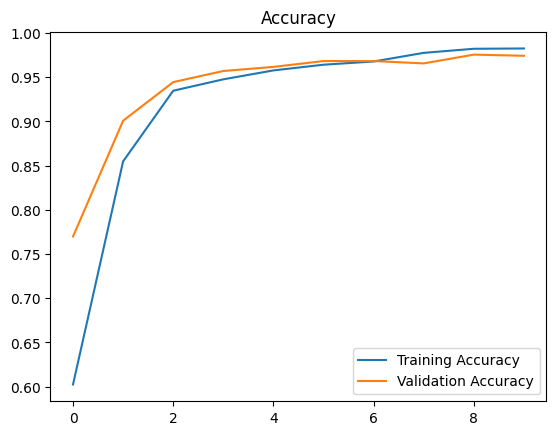

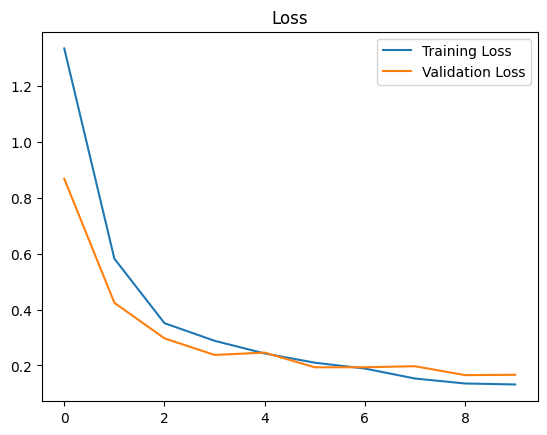

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Rekomedasi materi dengan data baru
def predict_sentence(sentence, tokenizer, model):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    predictions = model.predict(padded_sequence)
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class, predictions

# Penggunaan
sentence = "Create the function with complete the following Python code below: ___ hello(name):."
predicted_class, predictions = predict_sentence(sentence, tokenizer, model)

print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted class: [5]
Class probabilities: [[0.00425658 0.00242459 0.00316924 0.00518157 0.00372996 0.9665142
  0.00344457 0.01127925]]


In [ ]:
import pickle
from tensorflow.keras.models import load_model

# Menyimpan model dan tokenizer
model.save("model_codey.h5")

# Menyimpan tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
model.save('/content/drive/My Drive/Juliasmita/Bangkit2024/Capstone_Project/CodeyAPP/models/model_codey.h5')
with open('/content/drive/My Drive/Juliasmita/Bangkit2024/Capstone_Project/CodeyAPP/models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Simpan model dengan ekstensi .keras
checkpoint = ModelCheckpoint('/content/drive/My Drive/Juliasmita/Bangkit2024/Capstone_Project/CodeyAPP/models/best_model.keras', save_best_only=True)
model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint])

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.9911 - loss: 0.0842
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.9924 - loss: 0.0784
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.9955 - loss: 0.0715
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.9941 - loss: 0.0709
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.9956 - loss: 0.0649
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 0.9949 - loss: 0.0678
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.9948 - loss: 0.0677
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 152ms/step - accuracy: 0.9973 - loss: 0.0587
Epoch 9/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.9966 - loss: 0.0599
Epoch 10/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.9975 - loss: 0.0551
